In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import metpy
import numpy as np
from working.sea_breeze.load_model_data import load_barra_wind_data, load_barra_variable, load_barra_static, load_era5_ml, load_era5_static, interp_model_level_to_z,get_intake_cat_era5,get_intake_cat
from working.sea_breeze.coastline_funcs import get_coastline_angle_kernel, fill_coastline_angles, rotate_u_v_coast
from working.sea_breeze.load_obs import load_half_hourly_stn_obs
import datetime as dt
import pandas as pd
import tqdm

In [2]:
from climtas.nci import GadiClient
client = GadiClient()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40427,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:46407,Total threads: 1
Dashboard: /proxy/37653/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:37795,


2024-10-18 17:08:06,177 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-46490b719a6aa100898b8e50285bab3d', 0, 0, 2) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: waiting
old run_spec: (<function getitem at 0x154e7b179000>, (('transpose-04190196d83412fa9548c2fe4cbe67ac', 0, 0, 2, 0), (slice(None, None, None), slice(None, None, None), slice(None, None, None), 0)), {})
new run_spec: (<function execute_task at 0x154e6001c160>, (('transpose-vectorize_interp_np-vectorize_interp_np_0-getitem-46490b719a6aa100898b8e50285bab3d', 0, 0, 2),), {})
old token: ('tuple', (('3a54a0fe35af534a', []), ('tuple', (('tuple', ('tran

In [3]:
lat_slice=slice(-40,-37)
lon_slice=slice(146,150)
time_slice = slice("2024-01-20 00:00","2024-02-02 00:00")
stn_obs = load_half_hourly_stn_obs("VIC",time_slice)
era5, era5_lsm = load_era5_ml("/g/data/gb02/ab4502/era5_model_lvl/era5_test.nc",
                              time_slice.start,time_slice.stop,lat_slice,lon_slice)
barra = load_barra_wind_data(["uas"], ["vas"], ["ws"], time_slice.start, time_slice.stop, "AUS-11", "1hr", lat_slice, lon_slice)
barra_topo, barra_lsm = load_barra_static("AUS-11",lon_slice,lat_slice)

In [4]:
data_catalog = get_intake_cat_era5()
cat = get_intake_cat()
blh = data_catalog.search(variable="blh",product='era5-reanalysis',time_range="20240101-20240131").to_dask()
blh_barra = cat.search(variable_id="zmla",start_time=202401,domain_id="AUS-11",freq="1hr").to_dask()

In [5]:
angles_era5 = xr.open_dataset("/g/data/gb02/ab4502/coastline_data/era5_angles_v2.nc").sel({"lon":era5.lon,"lat":era5.lat})
angles_barra = xr.open_dataset("/g/data/gb02/ab4502/coastline_data/barra_r_angles_v2.nc").sel({"lon":barra.lon,"lat":barra.lat})

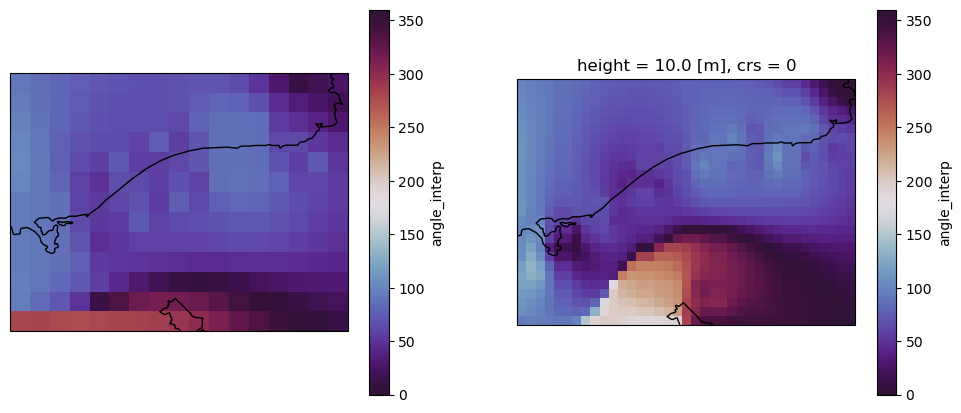

In [6]:
plt.figure(figsize=[12,5])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
angles_era5.angle_interp.plot(vmin=0,vmax=360,cmap="twilight_shifted")
#xr.plot.contour(angles_era5.coast,colors=["k"],levels=[0])
ax.coastlines()

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
angles_barra.angle_interp.plot(vmin=0,vmax=360,cmap="twilight_shifted")
#xr.plot.contour(angles_barra.coast,colors=["k"],levels=[0])
ax.coastlines()

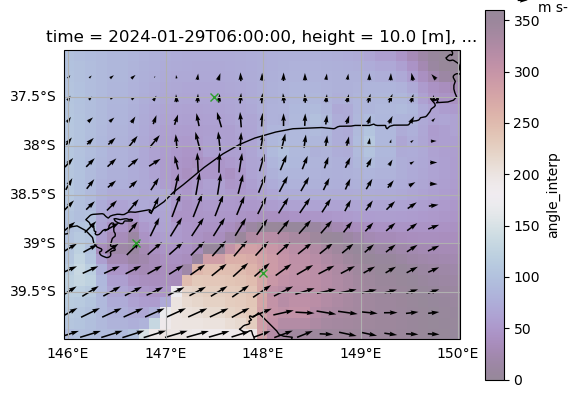

In [7]:
ax=plt.axes(projection=ccrs.PlateCarree())
angles_barra.angle_interp.plot(vmin=0,vmax=360,cmap="twilight_shifted",alpha=0.5)
barra.sel(time="2024-01-29 06:00").isel(lat=slice(0,-1,2),lon=slice(0,-1,2)).plot.quiver(x="lon",y="lat",u="uas",v="vas")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"])
ax.plot(147.5,-37.5, color="tab:green", marker="x")
ax.plot(148,-39.3, color="tab:green", marker="x")
ax.plot(146.7,-39, color="tab:green", marker="x")

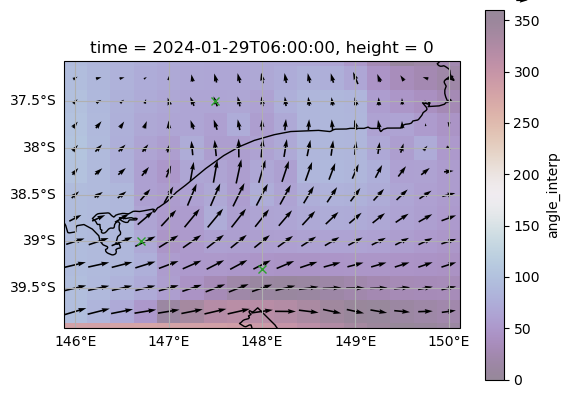

In [8]:
ax=plt.axes(projection=ccrs.PlateCarree())
angles_era5.angle_interp.plot(vmin=0,vmax=360,cmap="twilight_shifted",alpha=0.5)
era5.sel(height=0,time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v")
ax.set_ylim([barra.lat.min(),barra.lat.max()])
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"])
ax.plot(147.5, -37.5, color="tab:green", marker="x")
ax.plot(148,-39.3, color="tab:green", marker="x")
ax.plot(146.7,-39, color="tab:green", marker="x")

In [9]:
barra_uprime, barra_vprime = rotate_u_v_coast(barra["uas"], barra["vas"], angles_barra["angle_interp"])
era5_uprime, era5_vprime = rotate_u_v_coast(era5["u"], era5["v"], angles_era5["angle_interp"])

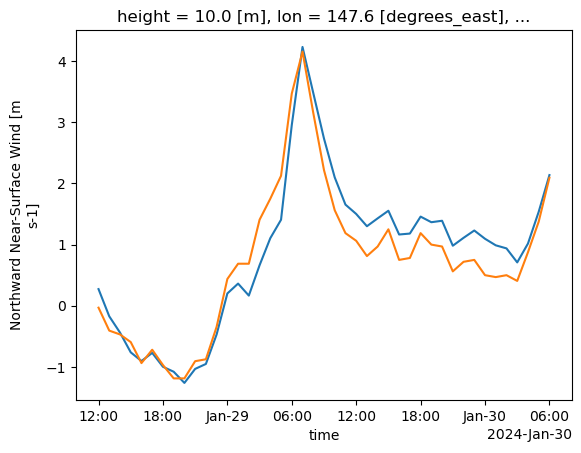

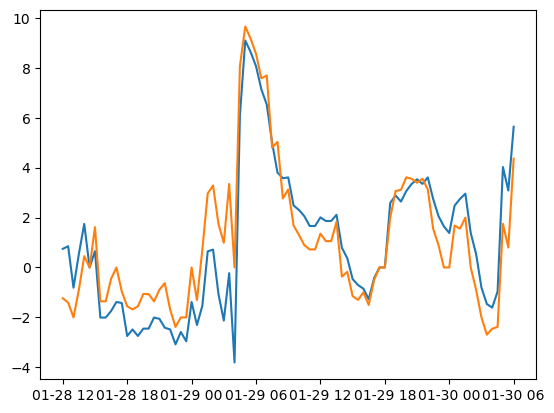

In [10]:
barra_vprime.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00")).sel(lon=147.5,lat=-37.5,method="nearest").plot()
barra["vas"].sel(time=slice("2024-01-28 12:00","2024-01-30 06:00")).sel(lon=147.5,lat=-37.5,method="nearest").plot()

plt.figure()
u = stn_obs.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00"),station=40).u.values
v = stn_obs.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00"),station=40).v.values
angle = angles_barra.sel(lon=stn_obs.sel(station=40).long, lat=stn_obs.sel(station=40).lati,method="nearest").angle_interp.values

obs_uprime, obs_vprime = rotate_u_v_coast(u, v, angle)

plt.plot(stn_obs.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00"),station=40).time, obs_vprime)
plt.plot(stn_obs.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00"),station=40).time, v)

#Vprime is the cross-shore component based on the rotated wind. However, this approach doesn't consider a consistent +ve/-ve direction (could be either onshore or offshore)

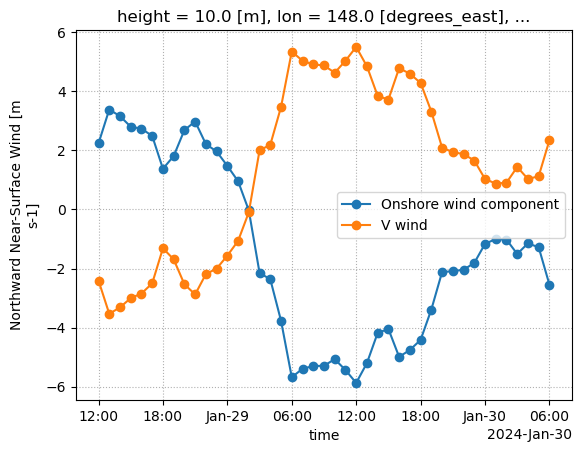

In [11]:
barra_vprime.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00")).sel(lon=148, lat=-39.3,method="nearest").plot(label="Onshore wind component",marker="o")
barra["vas"].sel(time=slice("2024-01-28 12:00","2024-01-30 06:00")).sel(lon=148, lat=-39.3,method="nearest").plot(label="V wind",marker="o")
plt.legend()
plt.gca().grid(ls=":")

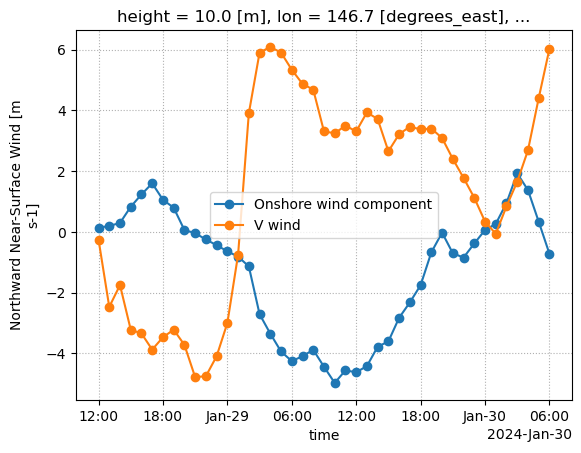

In [12]:
barra_vprime.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00")).sel(lon=146.7, lat=-39,method="nearest").plot(label="Onshore wind component",marker="o")
barra["vas"].sel(time=slice("2024-01-28 12:00","2024-01-30 06:00")).sel(lon=146.7, lat=-39,method="nearest").plot(label="V wind",marker="o")
plt.legend()
plt.gca().grid(ls=":")

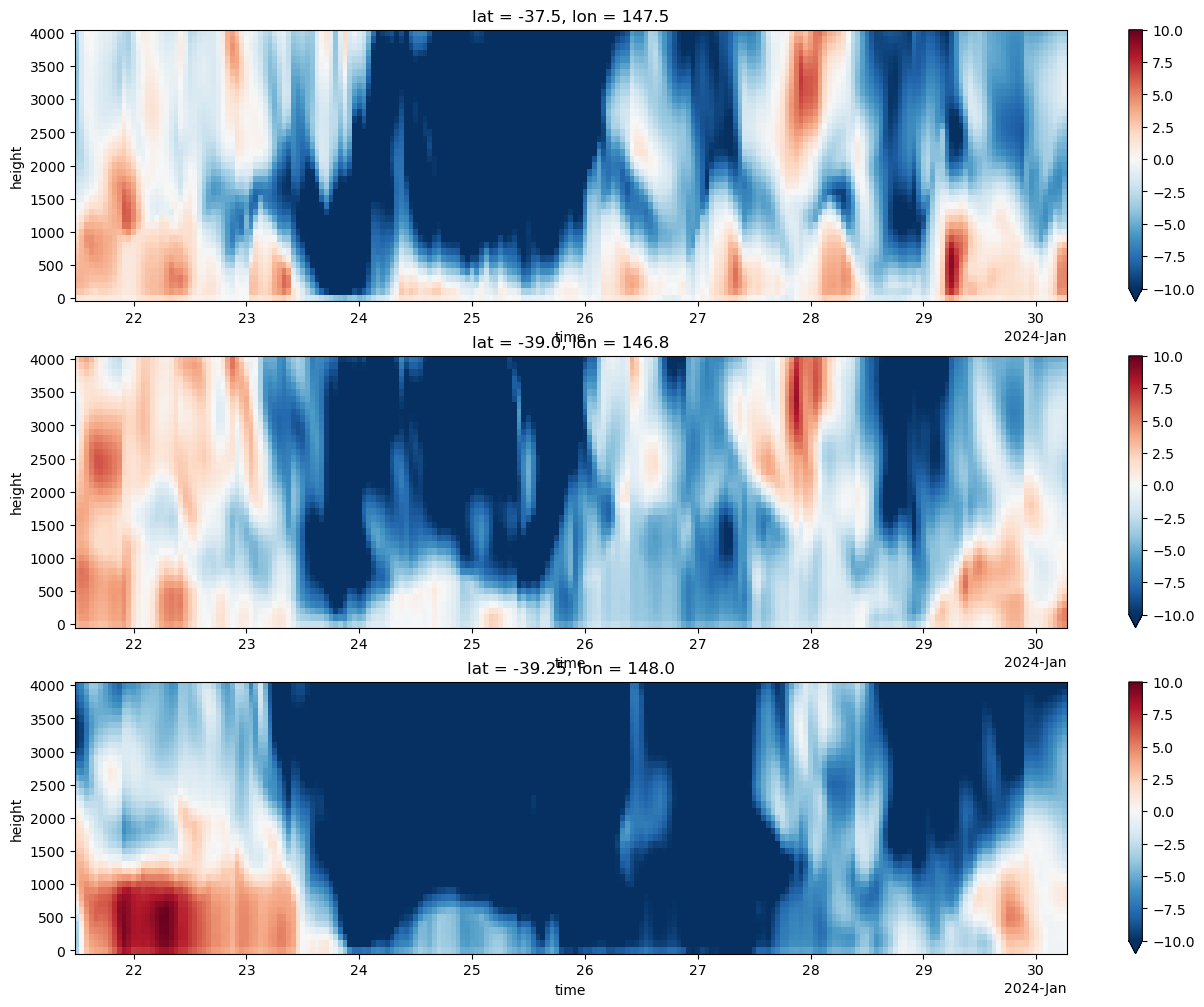

In [13]:
plt.figure(figsize=[16,12])
plt.subplot(3,1,1)
era5_vprime.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=147.5,lat=-37.5,method="nearest").plot(y="height",vmin=-10,vmax=10,cmap="RdBu_r")
plt.subplot(3,1,2)
era5_vprime.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=146.7,lat=-39,method="nearest").plot(y="height",vmin=-10,vmax=10,cmap="RdBu_r")
plt.subplot(3,1,3)
era5_vprime.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=148,lat=-39.3,method="nearest").plot(y="height",vmin=-10,vmax=10,cmap="RdBu_r")

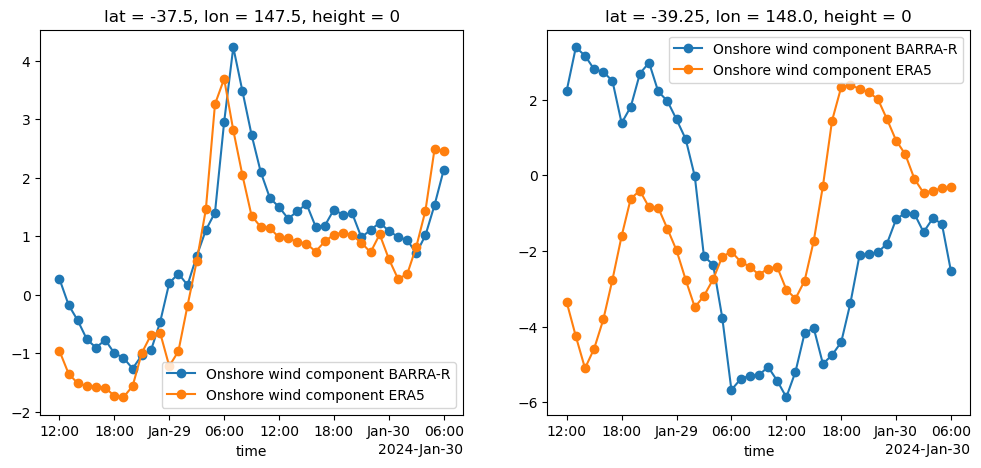

In [14]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
barra_vprime.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00")).sel(lon=147.5,lat=-37.5,method="nearest").plot(label="Onshore wind component BARRA-R",marker="o")
era5_vprime.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00"),height=0).sel(lon=147.5,lat=-37.5,method="nearest").plot(label="Onshore wind component ERA5",marker="o")
plt.legend()

plt.subplot(1,2,2)
barra_vprime.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00")).sel(lon=148, lat=-39.3,method="nearest").plot(label="Onshore wind component BARRA-R",marker="o")
era5_vprime.sel(time=slice("2024-01-28 12:00","2024-01-30 06:00"),height=0).sel(lon=148, lat=-39.3,method="nearest").plot(label="Onshore wind component ERA5",marker="o")
plt.legend()

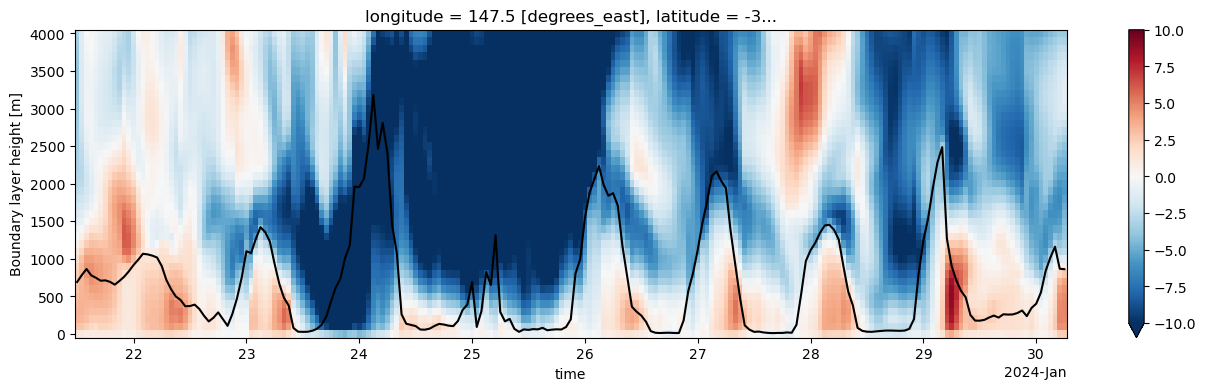

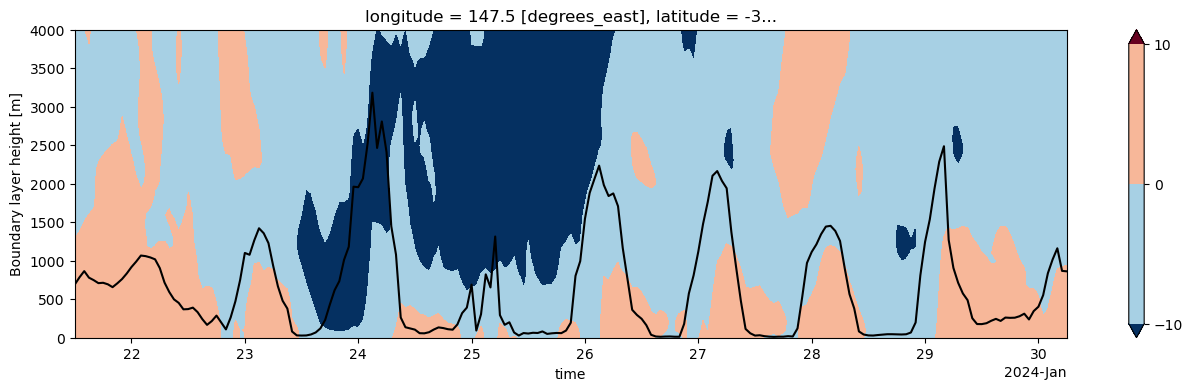

In [15]:
plt.figure(figsize=[16,4])
era5_vprime.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=147.5,lat=-37.5,method="nearest").plot(y="height",vmin=-10,vmax=10,cmap="RdBu_r")
blh.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=147.5,latitude=-37.5,method="nearest").blh.plot(color="k")

plt.figure(figsize=[16,4])
xr.plot.contourf(era5_vprime.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=147.5,lat=-37.5,method="nearest"),y="height",vmin=-10,vmax=10,cmap="RdBu_r",levels=[-10,0,10],extend="both")
blh.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=147.5,latitude=-37.5,method="nearest").blh.plot(color="k")

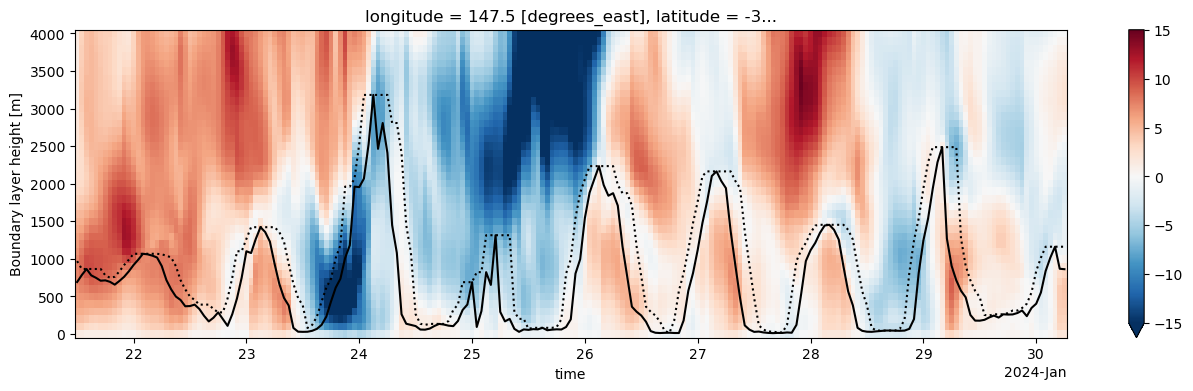

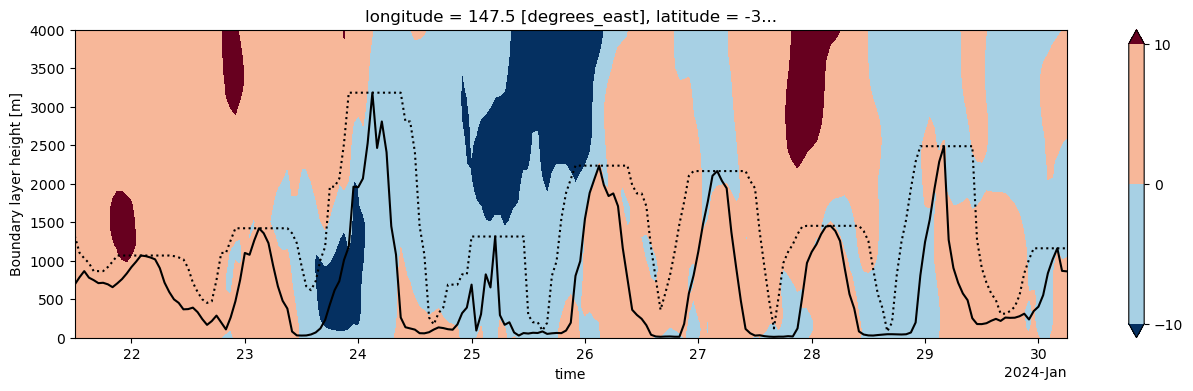

In [16]:
plt.figure(figsize=[16,4])
era5_vprime_7daymean = era5_vprime.rolling({"time":24*7},center=True,min_periods=25*3).mean()
(era5_vprime - era5_vprime_7daymean).sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=147.5,lat=-37.5,method="nearest").plot(y="height",vmin=-15,vmax=15,cmap="RdBu_r")
blh.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=147.5,latitude=-37.5,method="nearest").blh.plot(color="k")
blh.rolling({"time":6},center=True,min_periods=3).max().sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=147.5,latitude=-37.5,method="nearest").blh.plot(color="k",ls=":")

plt.figure(figsize=[16,4])
xr.plot.contourf((era5_vprime - era5_vprime_7daymean).sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=147.5,lat=-37.5,method="nearest"),y="height",vmin=-10,vmax=10,cmap="RdBu_r",levels=[-10,0,10],extend="both")
blh.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=147.5,latitude=-37.5,method="nearest").blh.plot(color="k")
blh.rolling({"time":12},center=True,min_periods=6).max().sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=147.5,latitude=-37.5,method="nearest").blh.plot(color="k",ls=":")

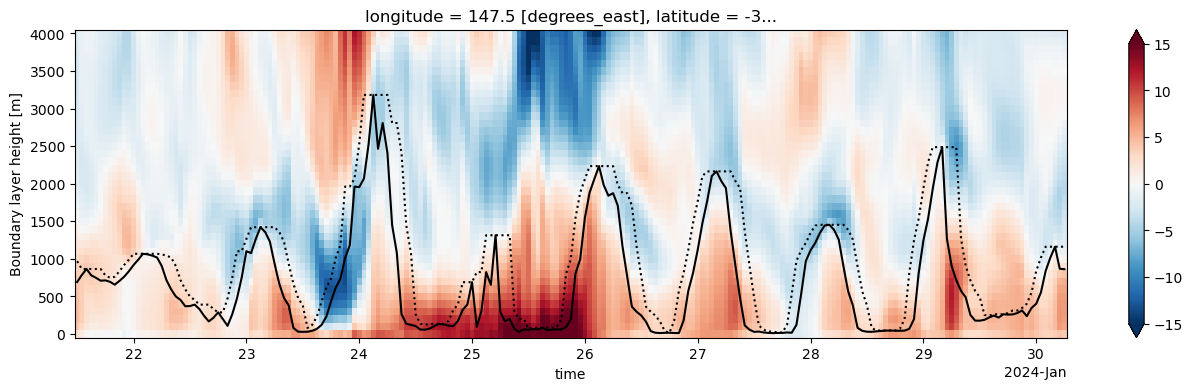

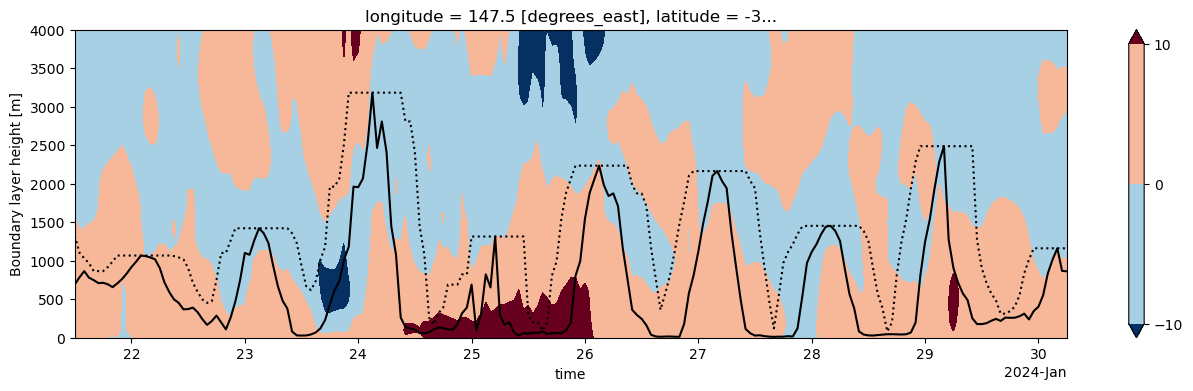

In [17]:
plt.figure(figsize=[16,4])
era5_vprime_7daymean = era5_vprime.rolling({"time":24*7},center=True,min_periods=25*3).mean()
(era5_vprime - era5_vprime.mean("height")).sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=147.5,lat=-37.5,method="nearest").plot(y="height",vmin=-15,vmax=15,cmap="RdBu_r")
blh.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=147.5,latitude=-37.5,method="nearest").blh.plot(color="k")
blh.rolling({"time":6},center=True,min_periods=3).max().sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=147.5,latitude=-37.5,method="nearest").blh.plot(color="k",ls=":")

plt.figure(figsize=[16,4])
xr.plot.contourf((era5_vprime - era5_vprime.mean("height")).sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=147.5,lat=-37.5,method="nearest"),y="height",vmin=-10,vmax=10,cmap="RdBu_r",levels=[-10,0,10],extend="both")
blh.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=147.5,latitude=-37.5,method="nearest").blh.plot(color="k")
blh.rolling({"time":12},center=True,min_periods=6).max().sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=147.5,latitude=-37.5,method="nearest").blh.plot(color="k",ls=":")

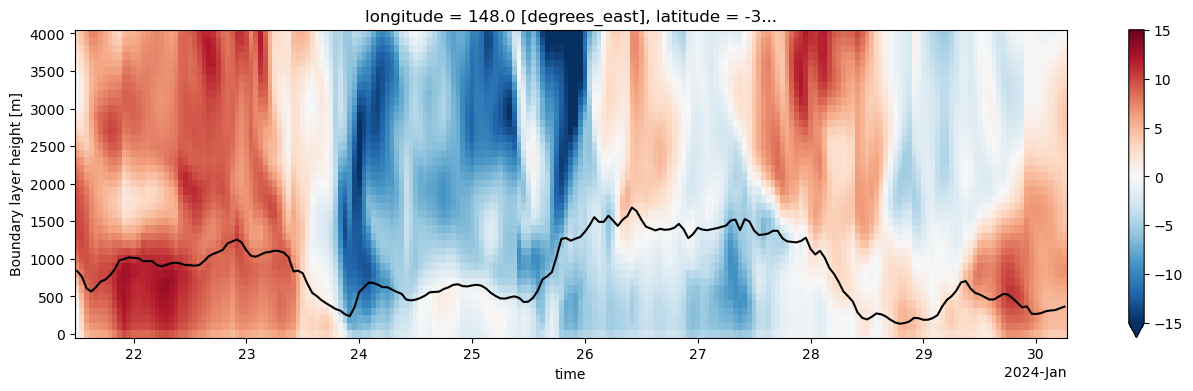

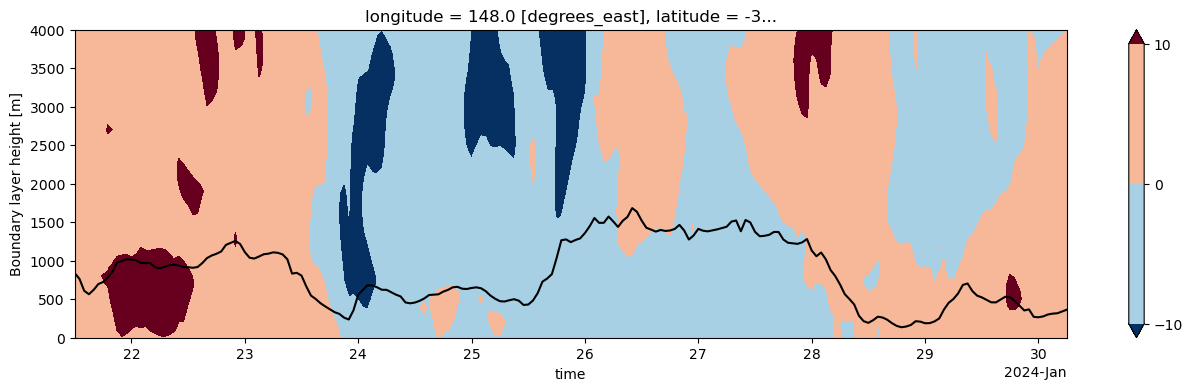

In [18]:
plt.figure(figsize=[16,4])
era5_vprime_7daymean = era5_vprime.rolling({"time":24*7},center=True,min_periods=25*3).mean()
(era5_vprime - era5_vprime_7daymean).sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=148,lat=-39.3,method="nearest").plot(y="height",vmin=-15,vmax=15,cmap="RdBu_r")
blh.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=148,latitude=-39.3,method="nearest").blh.plot(color="k")

plt.figure(figsize=[16,4])
xr.plot.contourf((era5_vprime - era5_vprime_7daymean).sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(lon=148,lat=-39.3,method="nearest"),y="height",vmin=-10,vmax=10,cmap="RdBu_r",levels=[-10,0,10],extend="both")
blh.sel(time=slice("2024-01-21 12:00","2024-01-30 06:00")).sel(longitude=148,latitude=-39.3,method="nearest").blh.plot(color="k")

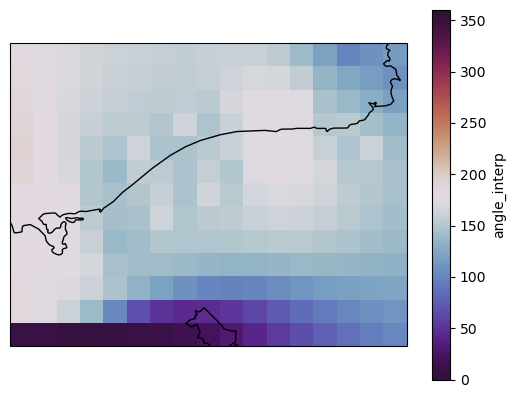

In [19]:
angle_ds = angles_era5
ax=plt.axes(projection=ccrs.PlateCarree())
theta = (((angle_ds.angle_interp+180)%360-90)%360)
theta.plot(cmap="twilight_shifted",vmin=0,vmax=360)
ax.coastlines()

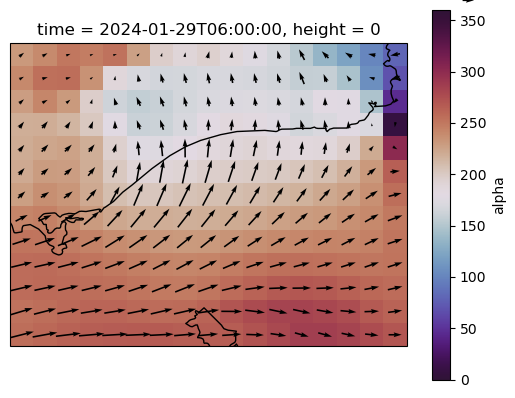

In [20]:
wind_ds = era5

alpha_height = 0

alpha = (90 - np.rad2deg(np.arctan2(-wind_ds["v"].sel(height=alpha_height), -wind_ds["u"].sel(height=alpha_height)))) % 360
beta = (90 - np.rad2deg(np.arctan2(-wind_ds["v"], -wind_ds["u"]))) % 360
wind_ds["alpha"] = alpha
wind_ds["beta"] = beta

ax=plt.axes(projection=ccrs.PlateCarree())
wind_ds.sel(time="2024-01-29 06:00").alpha.plot(cmap="twilight_shifted",vmin=0,vmax=360)
wind_ds.sel(height=0,time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

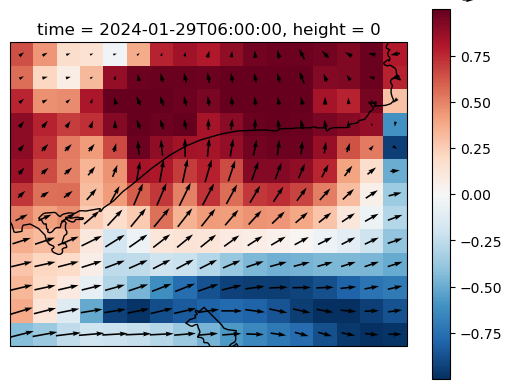

In [21]:
#np.cos(np.deg2rad((wind_ds.alpha.transpose("time","height","lat","lon").values - theta))).sel(time="2024-01-29 06:00",height=0).plot()
ax=plt.axes(projection=ccrs.PlateCarree())
onshore = np.cos(np.deg2rad((wind_ds.alpha - theta)))
onshore.sel(time="2024-01-29 06:00").plot()
wind_ds.sel(height=0,time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()


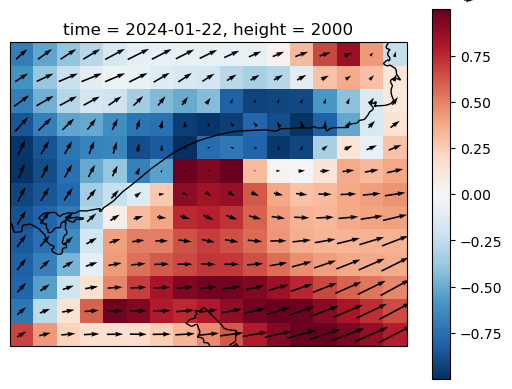

In [36]:
#np.cos(np.deg2rad((wind_ds.alpha.transpose("time","height","lat","lon").values - theta))).sel(time="2024-01-29 06:00",height=0).plot()
ax=plt.axes(projection=ccrs.PlateCarree())
#opposing = np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))
opposing = np.cos(np.deg2rad(wind_ds.beta - (theta + 180)))
opposing.sel(time="2024-01-22 00:00",height=2000).plot()
wind_ds.sel(height=2000,time="2024-01-22 00:00").plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()


In [24]:
angle_ds = angles_era5
wind_ds = era5

#Convert coastline orientation angle to the angle perpendicular to the coastline (from north)
theta = (((angle_ds.angle_interp+180)%360-90)%360)

#Calculate wind directions for low level (alpha) and all levels (beta)
alpha_height = 0
alpha = (90 - np.rad2deg(np.arctan2(-wind_ds["v"].sel(height=alpha_height), -wind_ds["u"].sel(height=alpha_height)))) % 360
beta = (90 - np.rad2deg(np.arctan2(-wind_ds["v"], -wind_ds["u"]))) % 360
wind_ds["alpha"] = alpha
wind_ds["beta"] = beta

#Calculate the sea breeze and land breeze indices
sbi = np.cos(np.deg2rad((wind_ds.alpha - theta))) * \
        np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))
lbi = -np.cos(np.deg2rad((wind_ds.alpha - theta))) * \
        np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))

In [25]:
sbi = np.cos(np.deg2rad((wind_ds.alpha - theta))) * \
        np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))
lbi = -np.cos(np.deg2rad((wind_ds.alpha - theta))) * \
        np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))

sb_cond = ( (np.cos(np.deg2rad((wind_ds.alpha - theta)))>0), #Low level flow onshore
        (np.cos(np.deg2rad(wind_ds.beta - (theta+180)))>0), #Upper level flow offshore
        (np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))>0) #Upper level flow opposing
              )
lb_cond = ( (np.cos(np.deg2rad((wind_ds.alpha - (theta+180))))>0), #Low level flow onshore
        (np.cos(np.deg2rad(wind_ds.beta - theta))>0), #Upper level flow offshore
        (np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))>0) #Upper level flow opposing
              )
sbi = xr.where(sb_cond[0] & sb_cond[1] & sb_cond[2], sbi, 0)
lbi = xr.where(lb_cond[0] & lb_cond[1] & lb_cond[2], lbi, 0)

In [28]:
sbi_plot = sbi.sel(height=slice(500,2000)).max("height").persist()
quiver_plot =  wind_ds[["u","v"]].sel(height=0).persist()

In [30]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*png
for t in tqdm.tqdm(pd.date_range("2024-01-20 06:00","2024-01-30 06:00",freq="1h")):
    plt.figure()
    ax=plt.axes(projection=ccrs.PlateCarree())
    sbi_plot.sel(time=t).plot(cmap="Blues",vmin=0,vmax=1)
    quiver_plot.sel(time=t).plot.quiver(x="lon",y="lat",u="u",v="v")
    ax.coastlines()
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()

100%|██████████| 241/241 [02:23<00:00,  1.68it/s]


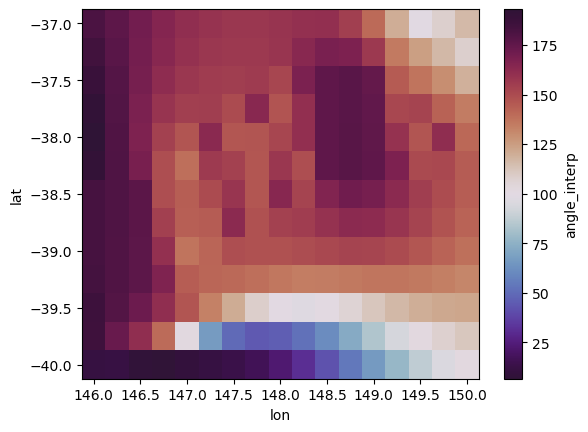

In [32]:
theta.plot(cmap="twilight_shifted")